In [1]:
#loading modules
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from difflib import get_close_matches
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')
import os

In [2]:
os.makedirs('models', exist_ok=True)

In [3]:
print(" Loading movie data...")
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

 Loading movie data...


In [4]:
# Preprocess movies
movies['genres'] = movies['genres'].str.split('|')
movies['genres_str'] = movies['genres'].apply(lambda x: ' '.join(x))
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)')

In [5]:
print(" Preparing recommendation engine...")
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))
tfidf_matrix = tfidf.fit_transform(movies['genres_str'])
cosine_sim = cosine_similarity(tfidf_matrix)

 Preparing recommendation engine...


In [6]:
# Save only top 50 neighbors per movie
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=50, metric='cosine', algorithm='brute')
knn.fit(tfidf_matrix)

,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",50
,"radius radius: float, default=1.0Range of parameter space to use by default for :meth:`radius_neighbors`queries.",1.0
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'brute'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30
,"metric metric: str or callable, default='minkowski'Metric to use for distance computation. Default is ""minkowski"", whichresults in the standard Euclidean distance when p = 2. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square during fit. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors.If metric is a callable function, it takes two arrays representing 1Dvectors as inputs and must return one value indicating the distancebetween those vectors. This works for Scipy's metrics, but is lessefficient than passing the metric name as a string.",'cosine'
,"p p: float (positive), default=2Parameter for the Minkowski metric fromsklearn.metrics.pairwise.pairwise_distances. When p = 1, this isequivalent to using manhattan_distance (l1), and euclidean_distance(l2) for p = 2. For arbitrary p, minkowski_distance (l_p) is used.",2
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run for neighbors search.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None


In [7]:
# Prepare count vectorizer for genre analysis
count_vec = CountVectorizer()
genre_matrix = count_vec.fit_transform(movies['genres_str'])

In [8]:
# Save models efficiently
import joblib
from scipy.sparse import save_npz
print("💾 Saving optimized models...")
joblib.dump(movies, 'models/movies.joblib')
joblib.dump(tfidf, 'models/tfidf.joblib')
save_npz('models/tfidf_matrix.npz', tfidf_matrix)  # Sparse format
joblib.dump(knn, 'models/knn_model.joblib')

print(f"✅ Models saved! Total size: {sum(os.path.getsize(f'models/{f}') for f in os.listdir('models'))/1024/1024:.2f} MB")

💾 Saving optimized models...
✅ Models saved! Total size: 4.31 MB


In [14]:
from difflib import get_close_matches

def find_similar_movies(movie_title, num_recommendations=5):
    """Find similar movies based on genre similarity"""
    # Find closest matching title
    all_titles = movies['title'].str.lower().tolist()
    close_matches = get_close_matches(movie_title.lower(), all_titles, n=1, cutoff=0.1)

    if not close_matches:
        print(f" No movies found matching '{movie_title}'")
        return None

    matched_title = close_matches[0]
    movie_idx = movies[movies['title'].str.lower() == matched_title].index[0]
    movie_data = movies.iloc[movie_idx]

    # Get similarity scores
    sim_scores = list(enumerate(cosine_sim[movie_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get top recommendations (skip the first which is the movie itself)
    movie_indices = [i[0] for i in sim_scores[1:num_recommendations+1]]
    recommendations = movies.iloc[movie_indices][['title', 'genres', 'year']]

    print(f"🎬 Showing recommendations similar to: '{movie_data['title']}'")

    return recommendations, movie_data


In [15]:
def visualize_genre_distribution(movie_data, recommendations):
    """Visualize genre distribution of recommendations"""
    # Get all genres from recommendations
    all_genres = [genre for sublist in recommendations['genres'] for genre in sublist]
    genre_counts = pd.Series(all_genres).value_counts()

    # Plot genre distribution
    plt.figure(figsize=(12, 6))
    genre_counts.plot(kind='bar', color='skyblue')
    plt.title('Genre Distribution in Recommendations')
    plt.xlabel('Genres')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Word cloud of genres
    plt.figure(figsize=(10, 6))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_genres))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Genre Word Cloud', pad=20)
    plt.axis('off')
    plt.show()

In [16]:
def visualize_similarity_matrix(movie_idx, recommendations):
    """Visualize similarity matrix for selected movies"""
    # Get indices of recommended movies
    rec_indices = recommendations.index.tolist()
    selected_indices = [movie_idx] + rec_indices
    selected_titles = movies.iloc[selected_indices]['title']

    # Create subset similarity matrix
    subset_sim = cosine_sim[selected_indices][:, selected_indices]

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        subset_sim,
        annot=True,
        fmt=".2f",
        cmap="YlOrRd",
        xticklabels=selected_titles,
        yticklabels=selected_titles
    )
    plt.title('Movie Similarity Matrix', pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


In [17]:
def visualize_release_years(recommendations):
    """Visualize release years of recommendations"""
    plt.figure(figsize=(10, 6))
    sns.histplot(data=recommendations, x='year', bins=20, kde=True, color='purple')
    plt.title('Release Year Distribution of Recommendations')
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [18]:
def display_recommendations(recommendations, movie_data):
    """Display recommendations with visualizations"""
    original_title = movie_data['title']
    print(f"\n🎬 Because you liked '{original_title}', we recommend:")
    print("="*70)
    for idx, row in recommendations.iterrows():
        print(f"🍿 {row['title']} ({row['year']})")
        print(f"   📌 Genres: {', '.join(row['genres'])}")
        print("-"*70)

    # Recommendation ranking visualization
    plt.figure(figsize=(12, 6))
    sns.barplot(
        x=np.arange(1, len(recommendations)+1),
        y=recommendations['title'],
        palette="viridis"
    )
    plt.title(f"Top {len(recommendations)} Similar Movies to '{original_title}'", pad=20)
    plt.xlabel("Recommendation Ranking")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

    # Additional visualizations
    visualize_genre_distribution(movie_data, recommendations)
    visualize_similarity_matrix(movie_data.name, recommendations)
    visualize_release_years(recommendations)


🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟
🎥 ENHANCED MOVIE RECOMMENDATION ENGINE
🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟🌟

Type a movie you like and get similar recommendations with visual analysis!
Type 'exit' to quit

🔍 Enter a movie title: The Dark Knight (2008)
🎬 Showing recommendations similar to: 'The Dark Knight (2011)'

🎬 Because you liked 'The Dark Knight (2011)', we recommend:
🍿 Léon: The Professional (a.k.a. The Professional) (Léon) (1994) (1994)
   📌 Genres: Action, Crime, Drama, Thriller
----------------------------------------------------------------------
🍿 Clear and Present Danger (1994) (1994)
   📌 Genres: Action, Crime, Drama, Thriller
----------------------------------------------------------------------
🍿 Last Man Standing (1996) (1996)
   📌 Genres: Action, Crime, Drama, Thriller
----------------------------------------------------------------------
🍿 Killer, The (Die xue shuang xiong) (1989) (1989)
   📌 Genres: Action, Crime, Drama, Thriller
-------------------------------------------

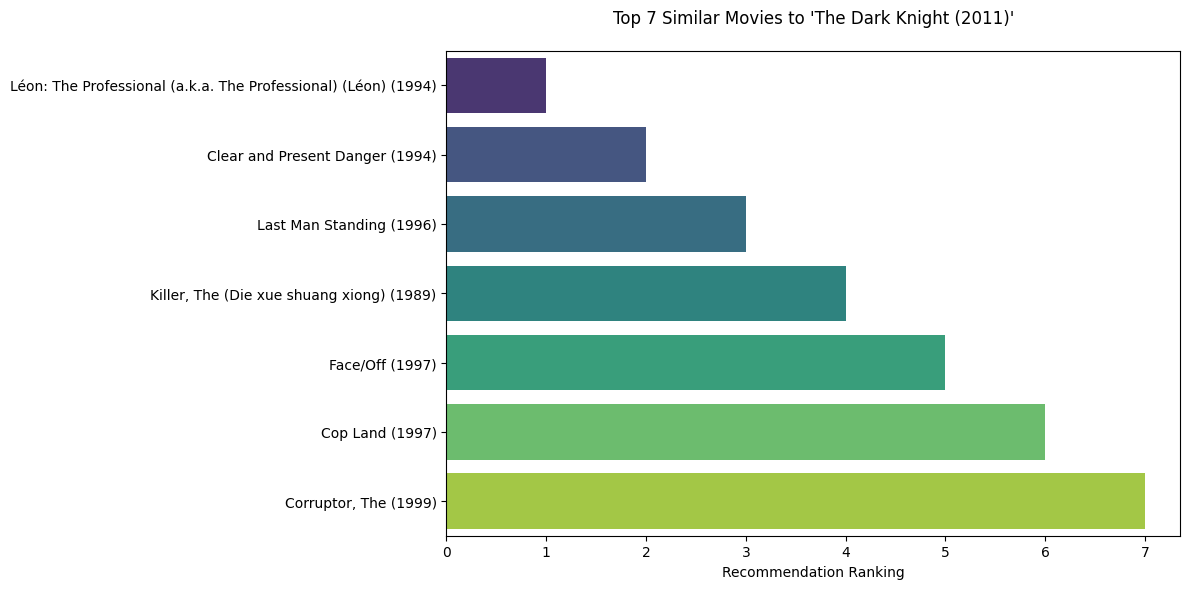

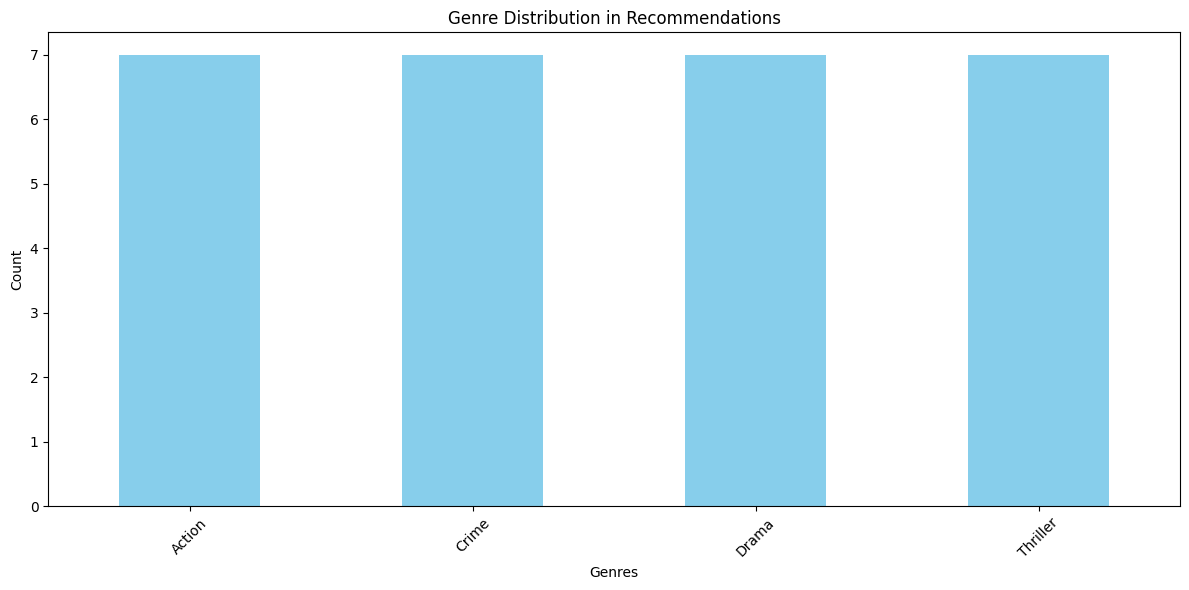

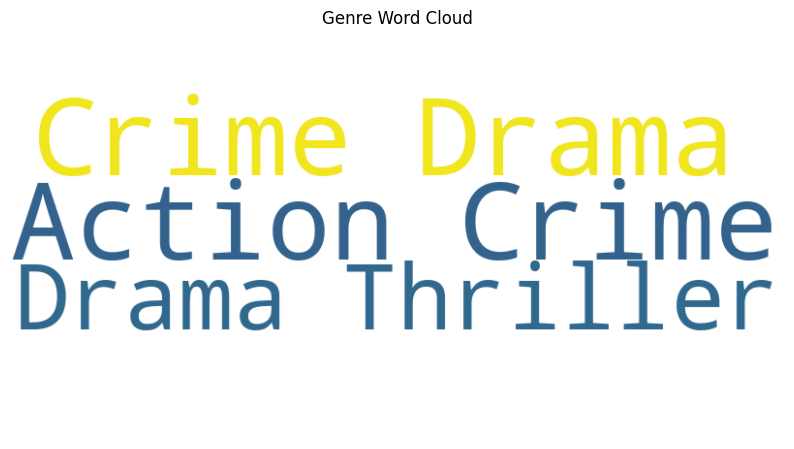

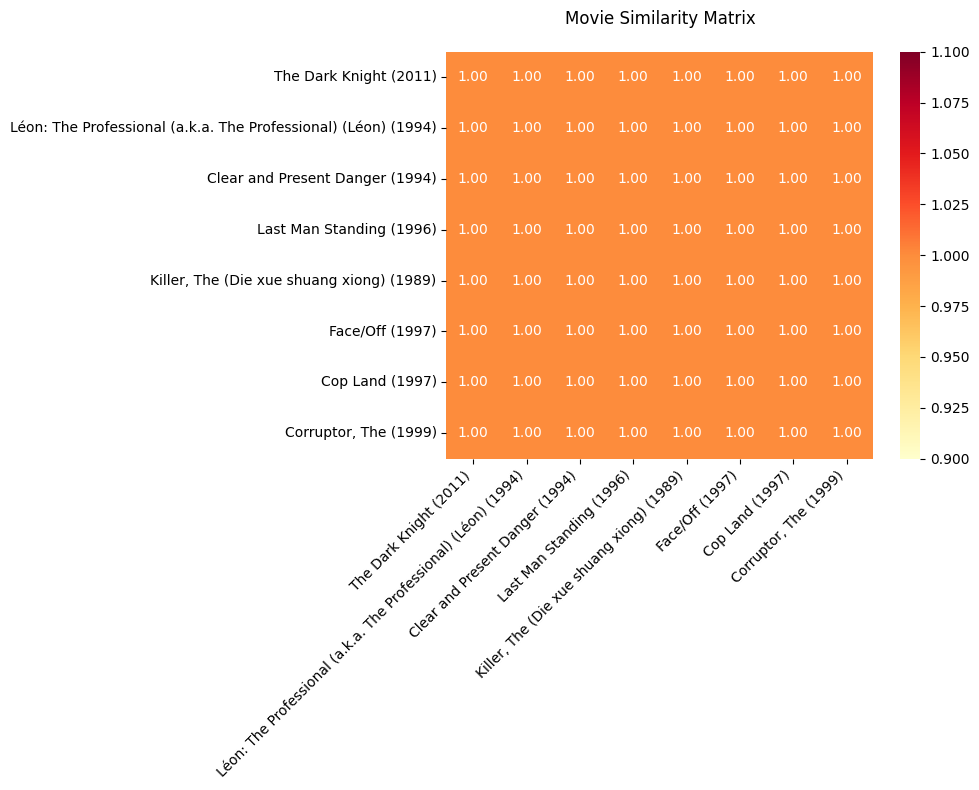

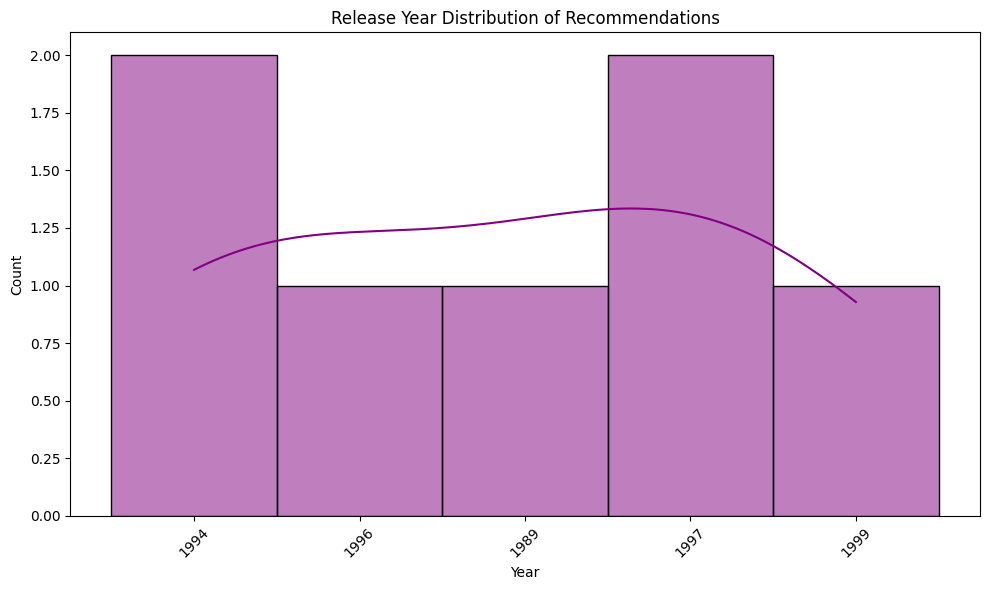


Want another recommendation? Just type another movie!

🔍 Enter a movie title: IT 2
🎬 Showing recommendations similar to: 'It (1927)'

🎬 Because you liked 'It (1927)', we recommend:
🍿 Sabrina (1995) (1995)
   📌 Genres: Comedy, Romance
----------------------------------------------------------------------
🍿 Clueless (1995) (1995)
   📌 Genres: Comedy, Romance
----------------------------------------------------------------------
🍿 Two if by Sea (1996) (1996)
   📌 Genres: Comedy, Romance
----------------------------------------------------------------------
🍿 French Twist (Gazon maudit) (1995) (1995)
   📌 Genres: Comedy, Romance
----------------------------------------------------------------------
🍿 If Lucy Fell (1996) (1996)
   📌 Genres: Comedy, Romance
----------------------------------------------------------------------
🍿 Boomerang (1992) (1992)
   📌 Genres: Comedy, Romance
----------------------------------------------------------------------
🍿 Pie in the Sky (1996) (1996)
   📌 Genr

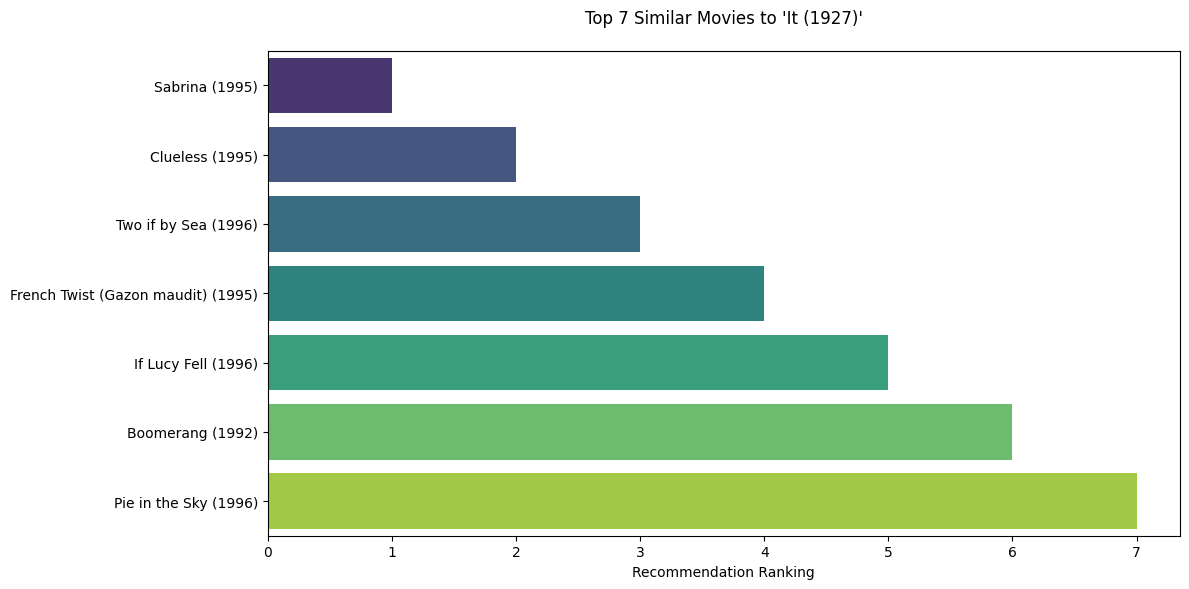

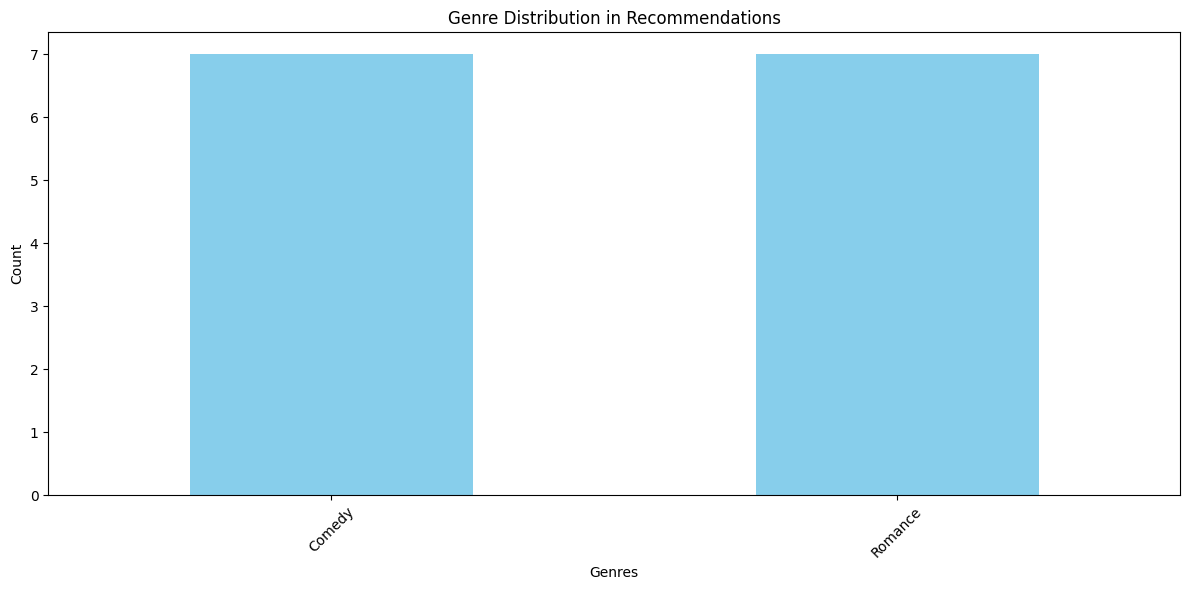

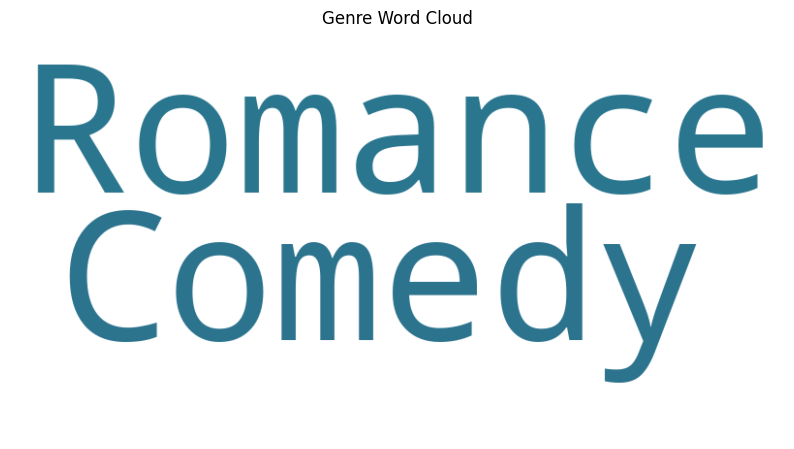

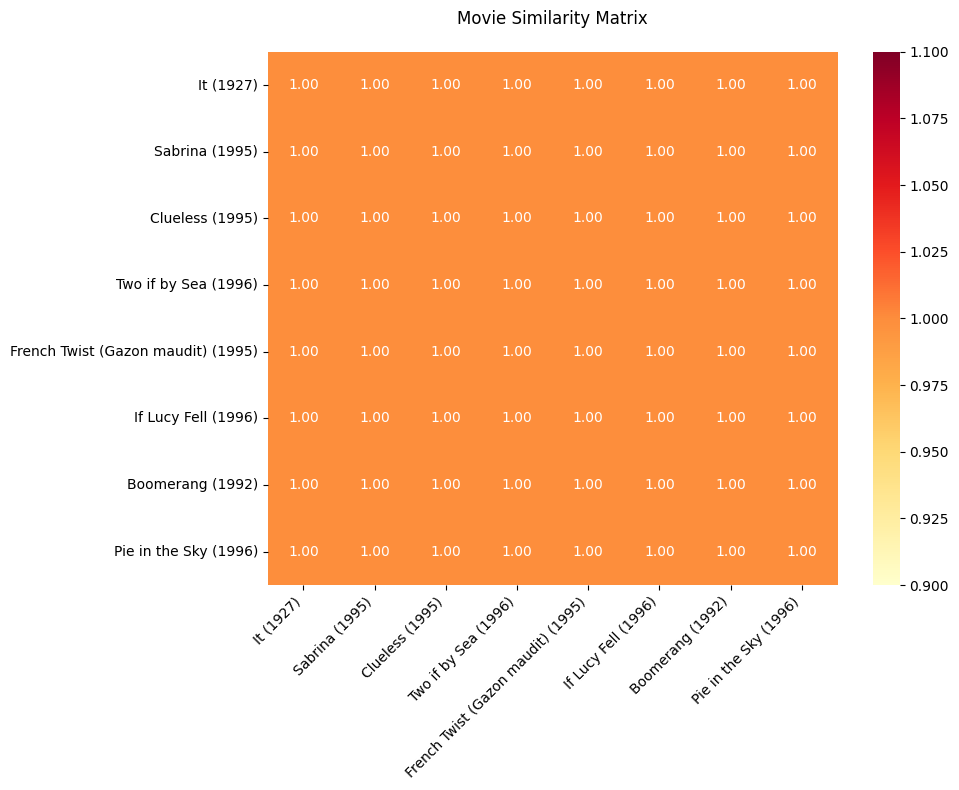

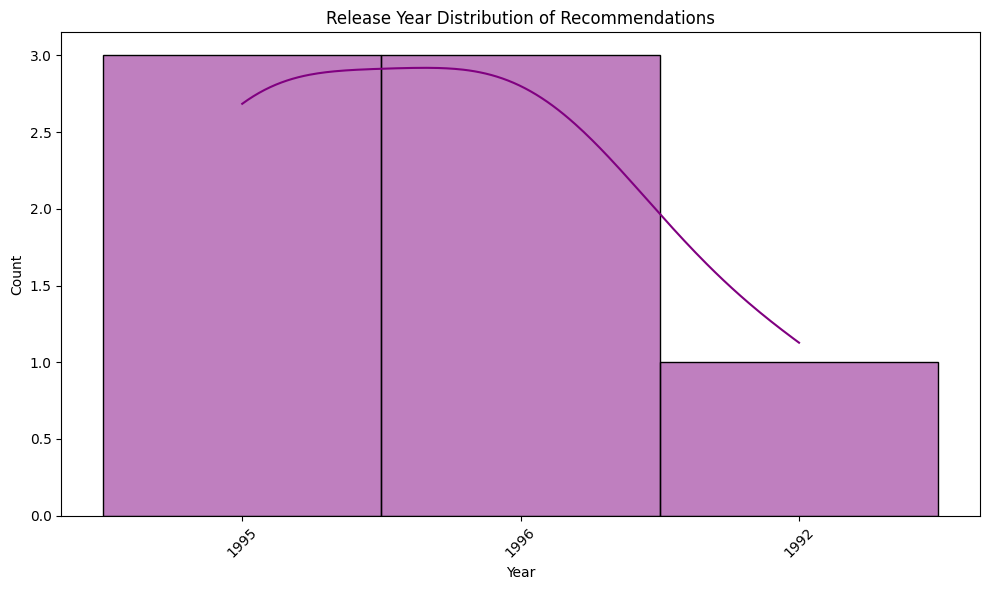


Want another recommendation? Just type another movie!

🔍 Enter a movie title: Toy Story
🎬 Showing recommendations similar to: 'Toy Story (1995)'

🎬 Because you liked 'Toy Story (1995)', we recommend:
🍿 Antz (1998) (1998)
   📌 Genres: Adventure, Animation, Children, Comedy, Fantasy
----------------------------------------------------------------------
🍿 Toy Story 2 (1999) (1999)
   📌 Genres: Adventure, Animation, Children, Comedy, Fantasy
----------------------------------------------------------------------
🍿 Adventures of Rocky and Bullwinkle, The (2000) (2000)
   📌 Genres: Adventure, Animation, Children, Comedy, Fantasy
----------------------------------------------------------------------
🍿 Emperor's New Groove, The (2000) (2000)
   📌 Genres: Adventure, Animation, Children, Comedy, Fantasy
----------------------------------------------------------------------
🍿 Monsters, Inc. (2001) (2001)
   📌 Genres: Adventure, Animation, Children, Comedy, Fantasy
--------------------------------

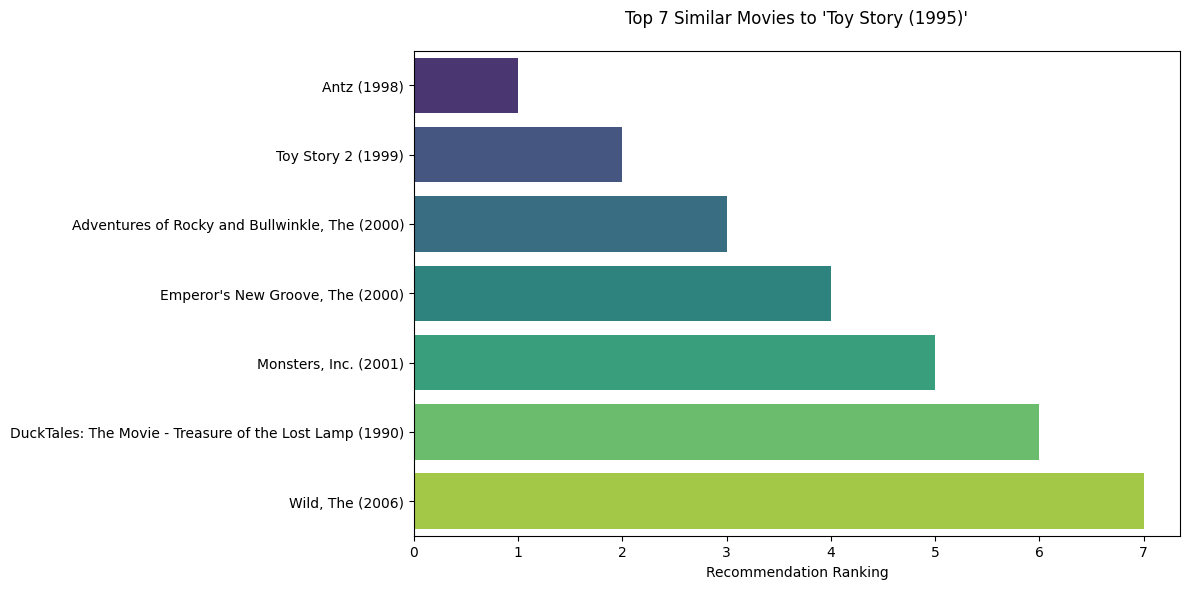

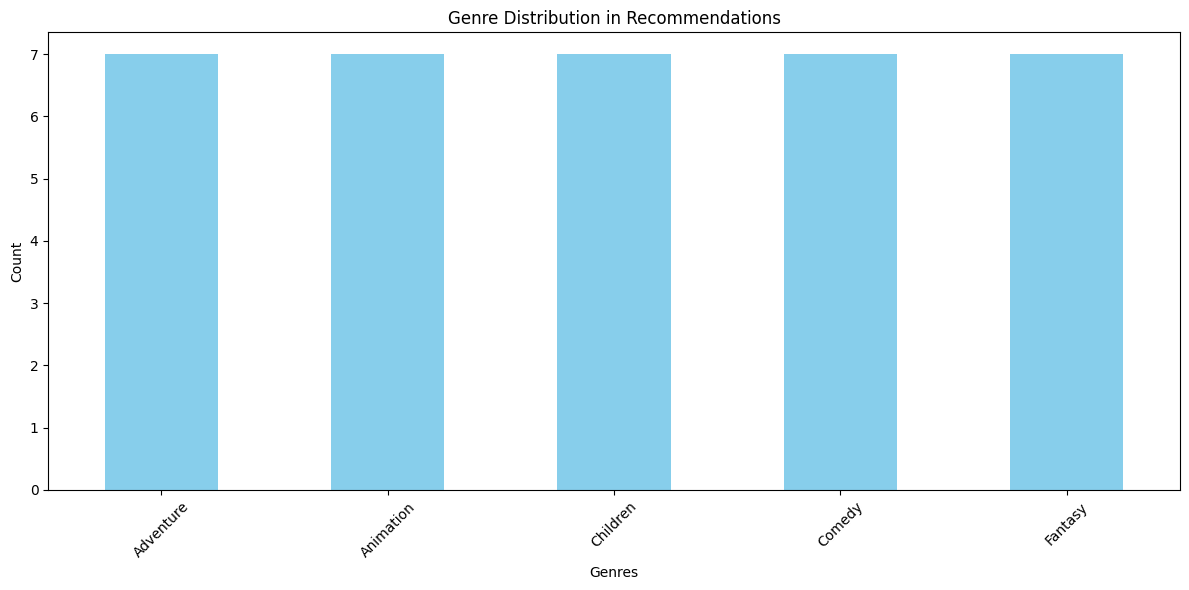

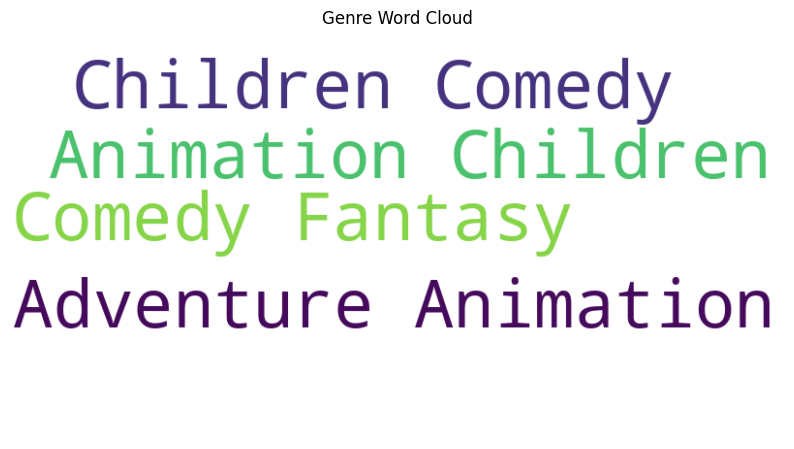

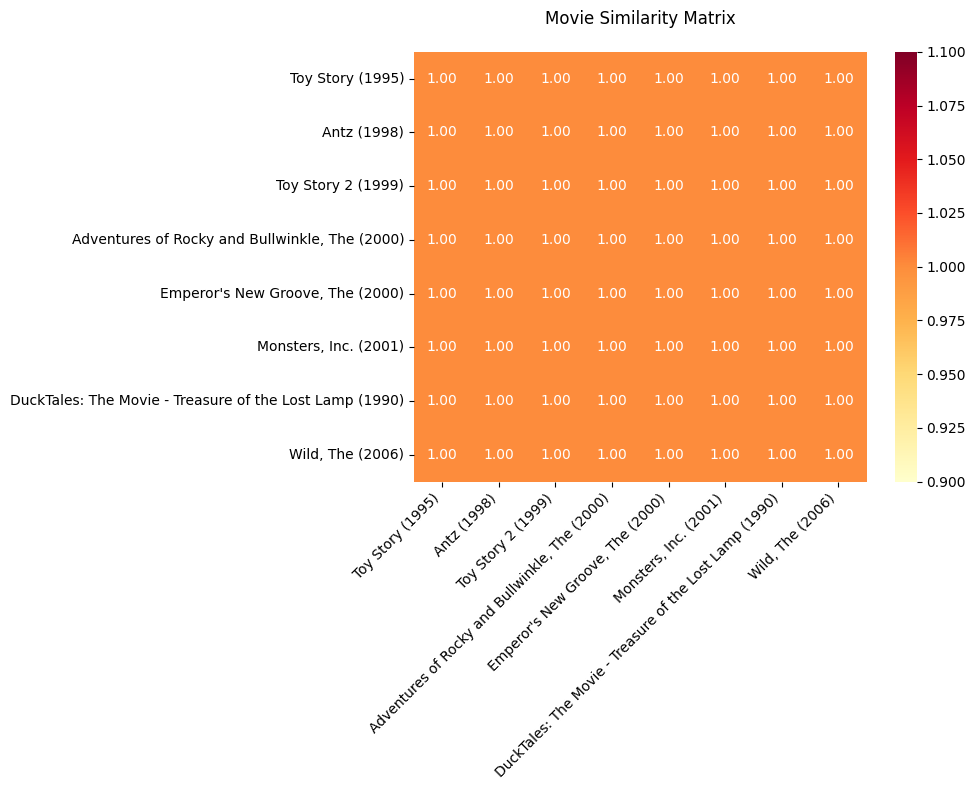

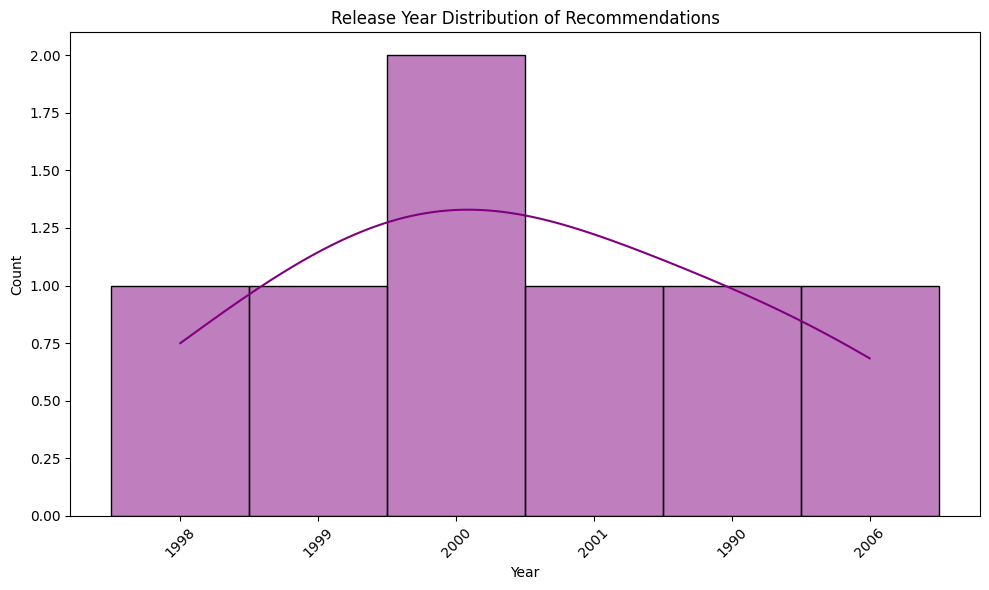


Want another recommendation? Just type another movie!



KeyboardInterrupt: Interrupted by user

In [19]:
def main():
    print("\n" + "🌟"*30)
    print("🎥 ENHANCED MOVIE RECOMMENDATION ENGINE")
    print("🌟"*30 + "\n")
    print("Type a movie you like and get similar recommendations with visual analysis!")
    print("Type 'exit' to quit\n")

    while True:
        user_input = input("🔍 Enter a movie title: ").strip()

        if user_input.lower() == 'exit':
            print("\n🎉 Thanks for using our recommendation system!")
            break

        if not user_input:
            print("⚠️ Please enter a movie title")
            continue

        results = find_similar_movies(user_input, num_recommendations=7)

        if results:
            recommendations, movie_data = results
            display_recommendations(recommendations, movie_data)

            print("\n" + "="*70)
            print("Want another recommendation? Just type another movie!")
            print("="*70 + "\n")

if __name__ == "__main__":
    main()